# TL;DR
1. Classification Setup show much better accuracy than the baseline.
2. The Feature Importance and SHAP values are consistent with the common sense.
3. The Classification Model reaches 0.999 ROC AUC score, which means the model could have learned more complex patterns, given bigger dataset.
4. There is a (small though) difference between the train and holdout metrics, which means the model is slightly overfitted. The model can be improved in the sense of robustness and generalization ability via feature selection.   

# Definitions

In [1]:
from dataclasses import dataclass, field
from pathlib import Path
from typing import Optional, List, Dict, Any

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from tqdm.notebook import tqdm
import shap

from validate import Model, Validator

In [2]:
shap.initjs()

In [3]:
data_path = Path('..', 'data')
data_path.exists()

True

In [4]:
targets = ['ltv_day1', 'ltv_day7', 'ltv_day30', 'ltv_day180']

# Data

In [5]:
train = pd.read_feather(data_path.joinpath('train.feather'))
train.info(verbose=True, show_counts=True)
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6994 entries, 0 to 6993
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   user_id                 6994 non-null   object        
 1   location                6994 non-null   object        
 2   gender                  6994 non-null   object        
 3   acquisition_date        6994 non-null   datetime64[ns]
 4   acquisition_channel     6994 non-null   object        
 5   eCPM                    6994 non-null   float64       
 6   total_time_spent        6994 non-null   float64       
 7   avg_session_time        6994 non-null   float64       
 8   num_games_played        6994 non-null   int64         
 9   favorite_game_genre     6994 non-null   object        
 10  total_rewards           6994 non-null   int64         
 11  total_coins             6994 non-null   int64         
 12  cashouts                6994 non-null   float64 

,user_id,location,gender,acquisition_date,acquisition_channel,eCPM,total_time_spent,avg_session_time,num_games_played,favorite_game_genre,...,cashouts,logins_past_7_days,total_logins,avg_daily_logins,notifications_received,ads_watched,ltv_day1,ltv_day7,ltv_day30,ltv_day180
0,u000000,Australia,Female,2024-04-08,In-App Ads,1.341458,128.150370,30.236412,65,Sports,...,173.913497,12,668,7.571228,54,131,2.500000,6.7,15.000000,40.0
1,u000001,France,Other,2023-09-28,In-App Ads,1.203097,34.064418,9.079346,97,Puzzle,...,85.865826,8,794,7.062567,22,336,2.500000,6.7,15.000000,40.0
2,u000002,Brazil,Male,2024-04-24,Referral,0.395693,96.559973,31.423285,97,Puzzle,...,195.228450,13,520,4.848931,54,182,2.311357,6.7,14.578598,25.0
3,u000003,Australia,Female,2023-10-17,In-App Ads,0.560207,691.653864,19.581271,19,Puzzle,...,154.958251,14,720,2.716627,7,404,2.500000,6.7,15.000000,40.0
4,u000004,Germany,Female,2023-12-15,Email,3.318075,411.067262,19.680246,7,Action,...,81.093215,14,175,3.753371,13,66,2.194381,6.7,15.000000,25.0


In [6]:
holdout = pd.read_feather(data_path.joinpath('holdout.feather'))
holdout.info(verbose=True, show_counts=True)
holdout.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3006 entries, 0 to 3005
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   user_id                 3006 non-null   object        
 1   location                3006 non-null   object        
 2   gender                  3006 non-null   object        
 3   acquisition_date        3006 non-null   datetime64[ns]
 4   acquisition_channel     3006 non-null   object        
 5   eCPM                    3006 non-null   float64       
 6   total_time_spent        3006 non-null   float64       
 7   avg_session_time        3006 non-null   float64       
 8   num_games_played        3006 non-null   int64         
 9   favorite_game_genre     3006 non-null   object        
 10  total_rewards           3006 non-null   int64         
 11  total_coins             3006 non-null   int64         
 12  cashouts                3006 non-null   float64 

,user_id,location,gender,acquisition_date,acquisition_channel,eCPM,total_time_spent,avg_session_time,num_games_played,favorite_game_genre,...,cashouts,logins_past_7_days,total_logins,avg_daily_logins,notifications_received,ads_watched,ltv_day1,ltv_day7,ltv_day30,ltv_day180
0,u000008,UK,Other,2024-06-09,Organic,3.314625,241.654864,36.662943,7,Strategy,...,64.641178,0,238,2.147985,11,153,2.5,6.7,15.0,40.0
1,u00000a,Australia,Other,2024-08-16,Referral,1.436349,197.260160,51.058547,67,Adventure,...,113.004473,13,392,7.490043,75,276,2.5,6.7,15.0,40.0
2,u00000b,Germany,Male,2024-07-11,Organic,3.324685,221.292736,59.881372,75,Action,...,123.754829,12,995,8.996471,61,275,2.5,6.7,15.0,40.0
3,u00000c,Germany,Female,2024-09-06,Social Media,1.884423,69.911627,32.670693,8,Adventure,...,188.125323,3,569,6.501001,38,51,2.5,6.7,15.0,40.0
4,u00000d,Brazil,Male,2024-06-05,In-App Ads,3.542221,93.525544,43.286937,90,Strategy,...,27.785314,5,712,3.789446,8,46,2.5,6.7,15.0,40.0


# Model

In [7]:
params = {
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'feature_fraction': 0.8,
    'learning_rate': 0.1,
    # 'max_depth': 5,
    # 'min_data_in_leaf': 0.1 * len(train_sample), # 30k
    'n_jobs': 6,
    # 'num_leaves': [10, 31, 150],
    'reg_alpha': 1,
    'reg_lambda': 1,
}
clf = lgb.LGBMClassifier(
    n_estimators=1000,
    **params,
)
clf

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.8,
               n_estimators=1000, n_jobs=6, reg_alpha=1, reg_lambda=1)

## Base Model to Evaluate Features

In [8]:
train_df, val_df = train_test_split(train, test_size=0.3, random_state=648)
train_df.shape, val_df.shape

((4895, 22), (2099, 22))

In [9]:
def get_xy(
    df: pd.DataFrame,
    target: str,
    clf_target_map: Optional[dict] = None,
    to_drop: List[str] = ['user_id', 'acquisition_date'],
    to_cat: List[str] = ['location', 'gender', 'acquisition_channel', 'favorite_game_genre'],
    drop_fluctuating: bool = True,
):
    y_raw = df[target]
    if clf_target_map is None:
        clf_target_map = dict(enumerate(y_raw.value_counts().head(2).index))
    reverse_map = {v: k for k, v in clf_target_map.items()}
    y = y_raw.map(reverse_map)
    
    X = df.drop(columns=targets + to_drop)
    for col in to_cat:
        X[col] = X[col].astype('category')
        
    if drop_fluctuating:
        mask = y.notna()
        return X[mask], y[mask], y_raw[mask], clf_target_map
    return X, y, y_raw, clf_target_map

In [10]:
X_train, y_train, y_raw_train, target_map = get_xy(train_df, 'ltv_day180')
X_train.shape, y_train.shape, target_map

((3362, 16), (3362,), {0: 40.0, 1: 25.0})

In [11]:
X_val, y_val, y_raw_val, _ = get_xy(val_df, 'ltv_day180', target_map)
X_val.shape, y_val.shape

((1466, 16), (1466,))

In [12]:
clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val), (X_train, y_train)],
    eval_metric='auc',
    callbacks=[
        lgb.callback.early_stopping(20, first_metric_only=True),
        lgb.callback.log_evaluation(period=10),
    ],
    categorical_feature='auto',
)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 1163, number of negative: 2199
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2524
[LightGBM] [Info] Number of data poin

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.8,
               n_estimators=1000, n_jobs=6, reg_alpha=1, reg_lambda=1)

In [13]:
fi = pd.DataFrame(
    {
        'feature': X_train.columns,
        'importance': clf.booster_.feature_importance(importance_type='gain'),
    }
)
fi.sort_values('importance', ascending=False, inplace=True)
fi

,feature,importance
8,total_rewards,14813.616356
10,cashouts,2061.788295
4,total_time_spent,202.636615
3,eCPM,123.857482
12,total_logins,109.981587
5,avg_session_time,106.871845
15,ads_watched,95.575770
13,avg_daily_logins,77.334363
9,total_coins,62.122849
14,notifications_received,61.338141


In [14]:
X_train, y_train, y_raw_train, target_map = get_xy(train_df, 'ltv_day180', drop_fluctuating=False)
X_val, y_val, y_raw_val, _ = get_xy(val_df, 'ltv_day180', target_map, drop_fluctuating=False)
X_test, y_test, y_raw_test, _ = get_xy(holdout, 'ltv_day180', target_map, drop_fluctuating=False)

In [15]:
def get_regr_pred(model, X, target_map):
    pred = model.predict(X)
    return pd.Series(pred).map(target_map)

In [16]:
y_pred_train = get_regr_pred(clf, X_train, target_map)
y_pred_val = get_regr_pred(clf, X_val, target_map)
y_pred_test = get_regr_pred(clf, X_test, target_map)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

In [17]:
def get_regr_metrics(y_true, y_pred):
    return {
        'mae': mean_absolute_error(y_true, y_pred),
        'rmse': root_mean_squared_error(y_true, y_pred),
    }

In [18]:
get_regr_metrics(y_raw_train, y_pred_train)

{'mae': np.float64(1.6790297436424921), 'rmse': np.float64(3.664100542011117)}

In [19]:
get_regr_metrics(y_raw_val, y_pred_val)

{'mae': np.float64(1.7281279265983802), 'rmse': np.float64(3.7850002465792265)}

In [20]:
get_regr_metrics(y_raw_test, y_pred_test)

{'mae': np.float64(1.7405825282302063), 'rmse': np.float64(3.7965710144867995)}

# Evaluation

In [21]:
@dataclass(slots=True)
class ClfModel(Model):
    name: str = 'clf_model'
    
    models: Dict[str, lgb.LGBMClassifier] = field(default_factory=dict)
    clf_maps: Dict[str, dict] = field(default_factory=dict)
    
    def fit(self, df: pd.DataFrame) -> "MedianModel":
        for target in tqdm(targets):
            train_df, val_df = train_test_split(df, test_size=0.3, random_state=648)
            X_train, y_train, _, target_map = self.get_xy(train_df, target)
            X_val, y_val, _, _ = self.get_xy(val_df, target, target_map)
            clf = lgb.LGBMClassifier(
                n_estimators=1000,
                **params,
            )
            clf.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val), (X_train, y_train)],
                eval_metric='auc',
                callbacks=[
                    lgb.callback.early_stopping(20, first_metric_only=True),
                    lgb.callback.log_evaluation(period=10),
                ],
                categorical_feature='auto',
            )
            self.models[target] = clf
            self.clf_maps[target] = target_map
            
        return self
    
    def predict(self, X: pd.DataFrame, target_name: str) -> pd.Series:
        X, _, _, _ = self.get_xy(
            X,
            target_name,
            self.clf_maps[target_name],
            drop_fluctuating=False,
        )
        return self.get_regr_pred(X, target_name)
    
    def get_params(self) -> Dict[str, Any]:
        return next(iter(self.models.values())).get_params()
    
    @staticmethod
    def get_xy(
        df: pd.DataFrame,
        target: str,
        clf_target_map: Optional[dict] = None,
        to_drop: List[str] = ['user_id', 'acquisition_date'],
        to_cat: List[str] = ['location', 'gender', 'acquisition_channel', 'favorite_game_genre'],
        drop_fluctuating: bool = True,
    ):
        y_raw = df[target]
        if clf_target_map is None:
            clf_target_map = dict(enumerate(y_raw.value_counts().head(2).index))
        reverse_map = {v: k for k, v in clf_target_map.items()}
        y = y_raw.map(reverse_map)
        
        X = df.drop(columns=targets + to_drop)
        for col in to_cat:
            X[col] = X[col].astype('category')
            
        if drop_fluctuating:
            mask = y.notna()
            return X[mask], y[mask], y_raw[mask], clf_target_map
        return X, y, y_raw, clf_target_map
    
    def get_regr_pred(self, X, target):
        pred = self.models[target].predict(X)
        return pd.Series(pred).map(self.clf_maps[target])

In [22]:
clf_model = ClfModel().fit(train)

  0%|          | 0/4 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 380, number of negative: 3738
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2526
[LightGBM] [Info] Number of data point

In [23]:
validator = Validator(train, holdout)

In [24]:
validator.log_metrics(clf_model)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aapiskotin-ge (justplay-case). Use `wandb login --relogin` to force relogin


# V2

In [25]:
@dataclass(slots=True)
class ClfModelV2(ClfModel):
    name: str = 'clf_model_v2'
    
    def get_regr_pred(self, X, target):
        probas = self.models[target].predict_proba(X)
        kernels = np.array([self.clf_maps[target][0], self.clf_maps[target][1]])
        return pd.Series((probas * kernels).sum(axis=1))

In [26]:
clf_model_v2 = ClfModelV2().fit(train)

  0%|          | 0/4 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 380, number of negative: 3738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGB

In [27]:
validator.log_metrics(clf_model_v2)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

# Interpretability

## SHAP Values

In [28]:
model = clf_model_v2.models['ltv_day30']
model

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.8,
               n_estimators=1000, n_jobs=6, reg_alpha=1, reg_lambda=1)

In [29]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

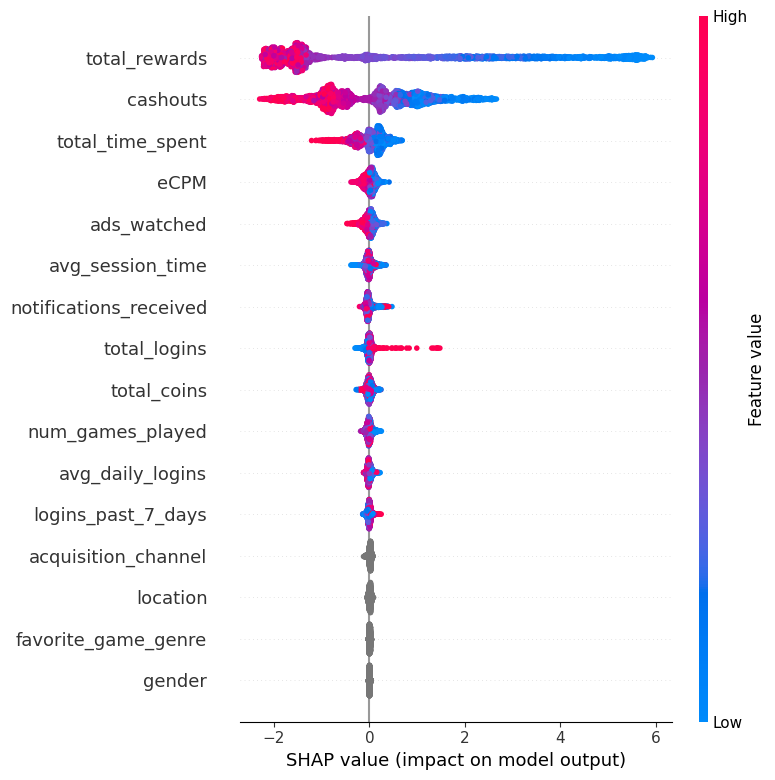

In [30]:
shap.summary_plot(shap_values, X_test)